In [1]:
import sys,os
sys.path.append('..')
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from backtester.swarms.manager import SwarmManager
from backtester.exoinfo import EXOInfo

import pandas as pd
import numpy as np
import scipy

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
swarms = {}
for file in os.listdir('./swarms/'):
    swarm_name = file.replace('.swm','')
    swarms[swarm_name] = SwarmManager.load(os.path.join('swarms', file))

In [4]:
swarms

{'EP_BearishCollarBrokenWing_SwingPoint_Bidir': <backtester.swarms.manager.SwarmManager at 0x7fa0760465c0>,
 'EP_BearishCollarBrokenWing_SwingPoint_Long': <backtester.swarms.manager.SwarmManager at 0x7fa0760463c8>,
 'EP_BearishCollarBrokenWing_SwingPoint_Short': <backtester.swarms.manager.SwarmManager at 0x7fa0760466d8>}

In [8]:
passive_exo = {}

exos_mat_files = [
    '../mat/strategy_270225.mat',
    #'../mat/strategy_2060248.mat',    
]

print('Passive EXO list')
for matfile in exos_mat_files:    
    exo = EXOInfo.from_matfile(matfile)
    passive_exo[exo.exo_name()] = exo.exo_price_index()
    
    print(exo.exo_name())

Passive EXO list
EP_BearishCollarBrokenWing_EXO


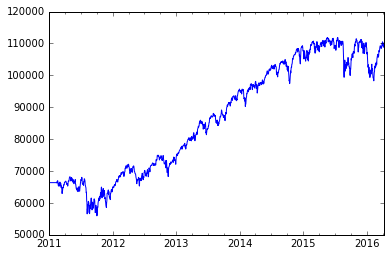

In [9]:
exo.data.fut_price.plot()

In [10]:

campaign_exposure = {
     'EP_BearishCollarBrokenWing_SwingPoint_Long': 1,
     'EP_BearishCollarBrokenWing_SwingPoint_Short': 1,
     
     #
     # Passive EXO positions
     #
     'EP_BearishCollarBrokenWing_EXO': -1, # Short 1 EXO units
     
}

In [11]:
#def campaign_equity(swarms, exposure):

campaign_dict = {}

for camp_name, exposure in campaign_exposure.items():
    if camp_name in swarms:
        swarm_name = camp_name
        smgr = swarms[swarm_name]
        campaign_dict[swarm_name] = smgr.swarm_picked.diff().sum(axis=1) * exposure
    elif camp_name in passive_exo:
        exo_equity = passive_exo[camp_name]
        campaign_dict[camp_name] = exo_equity.diff() * exposure
    
    
campaign_portfolio = pd.DataFrame(campaign_dict).cumsum()
campaign_equity = campaign_portfolio.sum(axis=1)

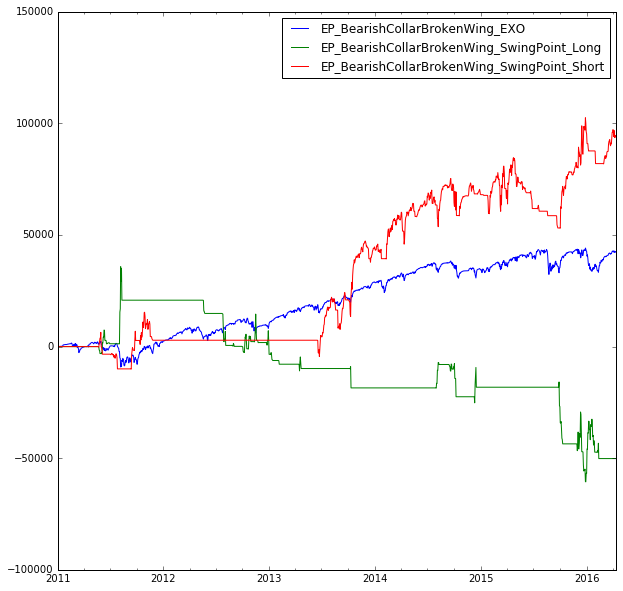

In [12]:
figsize(10,10)
campaign_portfolio.plot()

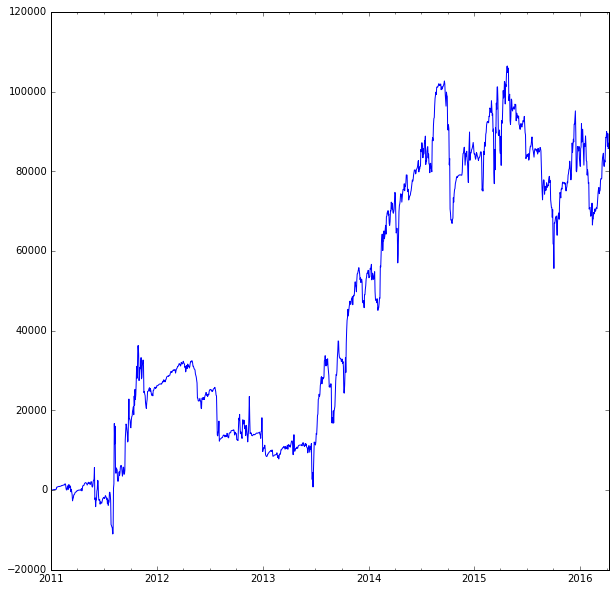

In [13]:
campaign_portfolio.sum(axis=1).plot()

## Campaign results

In [14]:
size_futures_long = 80
size_futures_short = -80
size_campaign = 40

In [15]:
futures_index = exo.data.fut_price.diff().cumsum()

## long/short futures

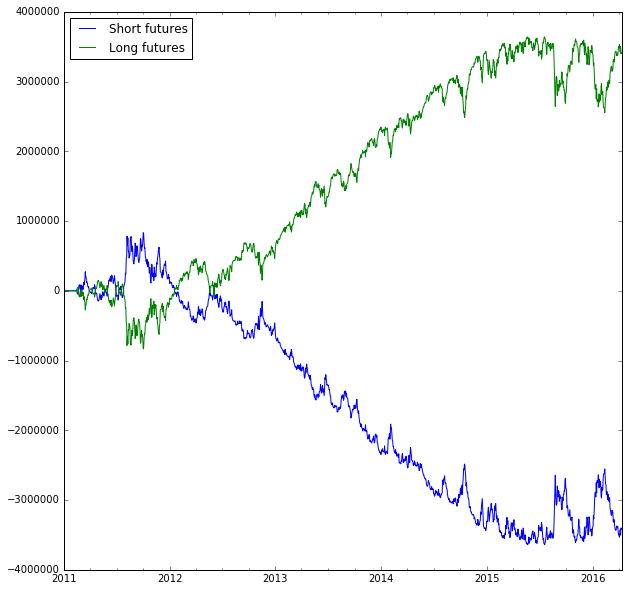

In [22]:
(futures_index*size_futures_short).plot(label='Short futures')
(futures_index*size_futures_long).plot(label='Long futures')

legend(loc=2)

## Futures and bidirectional campaign

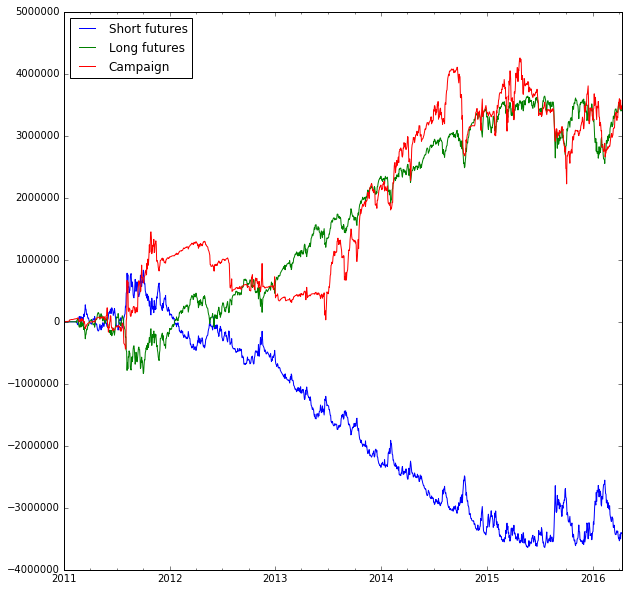

In [18]:
(futures_index*size_futures_short).plot(label='Short futures')
(futures_index*size_futures_long).plot(label='Long futures')
(campaign_equity*size_campaign).plot(label='Campaign')

legend(loc=2)

In [20]:
results_dict = {
    'long_futures_equity': futures_index*size_futures_long,
    'short_futures_equity': futures_index*size_futures_short,
    'campaign_equity': campaign_equity*size_campaign
}

pd.DataFrame(results_dict).to_csv('./swarms/campaign_results.csv')


In [21]:
import json
campaign_info = {
    'structure': campaign_exposure,
    'sizes': {
        'long_futures': size_futures_long,
        'short_futures': size_futures_short,
        'campaign_units': size_campaign
    }
}

with open('./swarms/campaign_info.json', 'w') as f:
    json.dump(campaign_info, f, indent=4)